# Traffic Signs Detection and Classfication
    - Buiding a deep convolutional neural network (CNN) classifer to clssfier traffic sign images to respective classes.
    - GTRSB dataset ise used for training, validation and testing.
    - Implemented a CNN with VGG net architecture.
    - Fit the model and tested it on new images from the web to analyze the performance.
    - Achived an training accuarcy of  98% and testing accuracy of 96%
    

# Importing libraries

In [5]:
import pickle
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import skimage.morphology as morp
from skimage.filters import rank
import Augmentor
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, ProgbarLogger
from tensorflow.python.keras import utils
from keras.layers import Activation, BatchNormalization, Conv2D, MaxPooling2D, Dropout,Dense, Flatten
from keras.models import Sequential
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import glob

%matplotlib inline 

# Step 1 : Load The Data 
This dataset contains the following three pickle files:

* train.p: The training set.
* valid.p: The validation set.
* test.p: The testing set.

In [6]:
# Load pickled data
training_data = 'GTRSB/train.p'
validation_data = 'GTRSB/valid.p'
testing_data = 'GTRSB/test.p'

with open(training_data, mode='rb') as f:
    train = pickle.load(f)
with open(validation_data, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_data, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Step 1: Dataset Summary & Exploration



In [7]:
# Mapping ClassID to traffic sign names

# load class-ids and sign names from csv file
def load_signnames_from_csv(filename):
    rows = []
    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)  # skip header
        for row in reader:
            class_id = row[0]
            sign_name = row[1]
            rows.append((class_id, sign_name))

    return np.array(rows)


sign_names = load_signnames_from_csv('signnames.csv')

for sign in sign_names:
    print('{:4d}: {}'.format(int(sign[0]), sign[1]))

   0: Speed limit (20km/h)
   1: Speed limit (30km/h)
   2: Speed limit (50km/h)
   3: Speed limit (60km/h)
   4: Speed limit (70km/h)
   5: Speed limit (80km/h)
   6: End of speed limit (80km/h)
   7: Speed limit (100km/h)
   8: Speed limit (120km/h)
   9: No passing
  10: No passing for vehicles over 3.5 metric tons
  11: Right-of-way at the next intersection
  12: Priority road
  13: Yield
  14: Stop
  15: No vehicles
  16: Vehicles over 3.5 metric tons prohibited
  17: No entry
  18: General caution
  19: Dangerous curve to the left
  20: Dangerous curve to the right
  21: Double curve
  22: Bumpy road
  23: Slippery road
  24: Road narrows on the right
  25: Road work
  26: Traffic signals
  27: Pedestrians
  28: Children crossing
  29: Bicycles crossing
  30: Beware of ice/snow
  31: Wild animals crossing
  32: End of all speed and passing limits
  33: Turn right ahead
  34: Turn left ahead
  35: Ahead only
  36: Go straight or right
  37: Go straight or left
  38: Keep right
  3

# Listing the number of training, validation and testing samples using numpy methods
# Number of classes in the dataset is also listed

In [8]:
# Number of training examples
n_train = len(X_train)
height = len(X_train[1])
width = len(X_train[2])
channels = X_train.shape[3]

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# shape of an traffic sign image
image_shape = X_train.shape

image_depth_dimension = X_train.shape[3]

# Number of unique classes/labels in the dataset.
n_classes = len(np.unique(y_train))
print("1. Number of training examples =", n_train)
print("2. Number of validation examples =", n_validation)
print("3. Number of testing examples =", n_test)
print("4. height =", height)
print("5. width =", width)
print("6. channels =",channels)
print("7. Image data shape =", image_shape)
print("8. Number of classes =",  n_classes)


1. Number of training examples = 34799
2. Number of validation examples = 4410
3. Number of testing examples = 12630
4. height = 32
5. width = 32
6. channels = 3
7. Image data shape = (34799, 32, 32, 3)
8. Number of classes = 43


# Dataset Visualization
Examinig how each class is represented in the dataset. This is done by histogram of images in each class

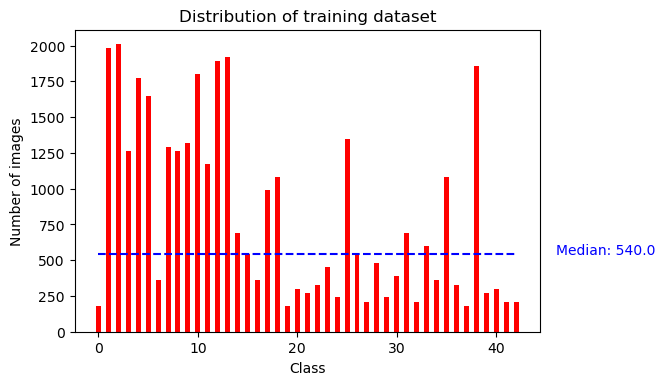


Median of images per class: 540.0


In [9]:
# histogram of class frequency
fig, ax = plt.subplots()
hist, bins = np.histogram(y_train, bins=n_classes)
center = np.array(range(0, n_classes))
median = np.median(hist)
ax.plot(bins, np.full(len(bins), median, dtype=int), '--', color='blue')
ax.bar(center, hist, align='center', width=0.5, color = 'red')
ax.set_title("Distribution of training dataset")
ax.set_xlabel('Class')
ax.set_ylabel('Number of images')
plt.text(n_classes+3, median, 'Median: {}'.format(median), color='blue')
fig.set_dpi(100)
plt.savefig('saved_data/class_distribution_1.png')
plt.show()

print()
print('Median of images per class: {}'.format(median))


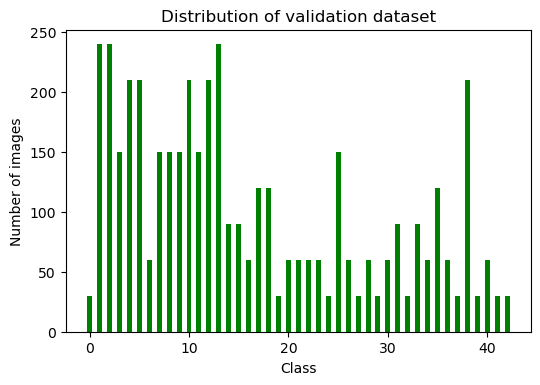

In [10]:
# histogram of class frequency
fig, ax = plt.subplots()
hist, bins = np.histogram(y_valid, bins=n_classes)
center = np.array(range(0, n_classes))
ax.bar(center, hist, align='center', width=0.5, color = 'green')
ax.set_title("Distribution of validation dataset")
ax.set_xlabel('Class')
ax.set_ylabel('Number of images')
fig.set_dpi(100)
plt.savefig('saved_data/class_distribution_1.png')
plt.show()

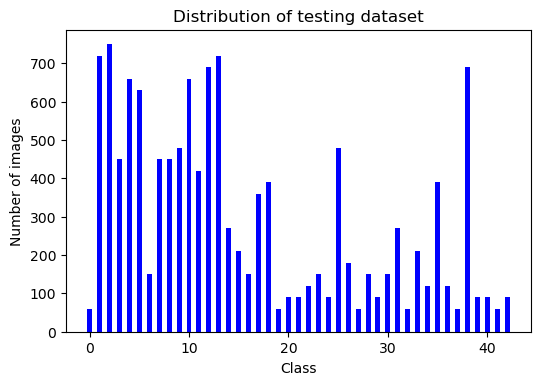

In [11]:
# histogram of class frequency
fig, ax = plt.subplots()
hist, bins = np.histogram(y_test, bins=n_classes)
center = np.array(range(0, n_classes))
ax.bar(center, hist, align='center', width=0.5, color = 'blue')
ax.set_title("Distribution of testing dataset")
ax.set_xlabel('Class')
ax.set_ylabel('Number of images')
fig.set_dpi(100)
plt.savefig('saved_data/class_distribution_1.png')
plt.show()

In [12]:
# # cut number of images per class to the median number images per class
# def equalize_images_per_class(data, labels, num_classes, threshold):
#     images = []
#     classes = []
#     for class_id in range(0, num_classes):
#         group = data[labels == class_id]
#         if len(group) > threshold:
#             group = group[:threshold]

#         for image in group:
#             images.append(image)
#             classes.append(class_id)
#     return np.array(images), np.array(classes)

# X_train, y_train = equalize_images_per_class(X_train, y_train, n_classes, int(median))

# # histogram of class frequency
# fig, ax = plt.subplots()
# hist, bins = np.histogram(y_train, bins=n_classes)
# center = np.array(range(0, n_classes))
# ax.bar(center, hist, align='center', width=0.8)
# ax.set_title("Number of images per class")
# ax.set_xlabel('Class')
# ax.set_ylabel('Number of images')
# fig.tight_layout()
# plt.savefig('saved_data/class_distribution_2.png')
# plt.show()

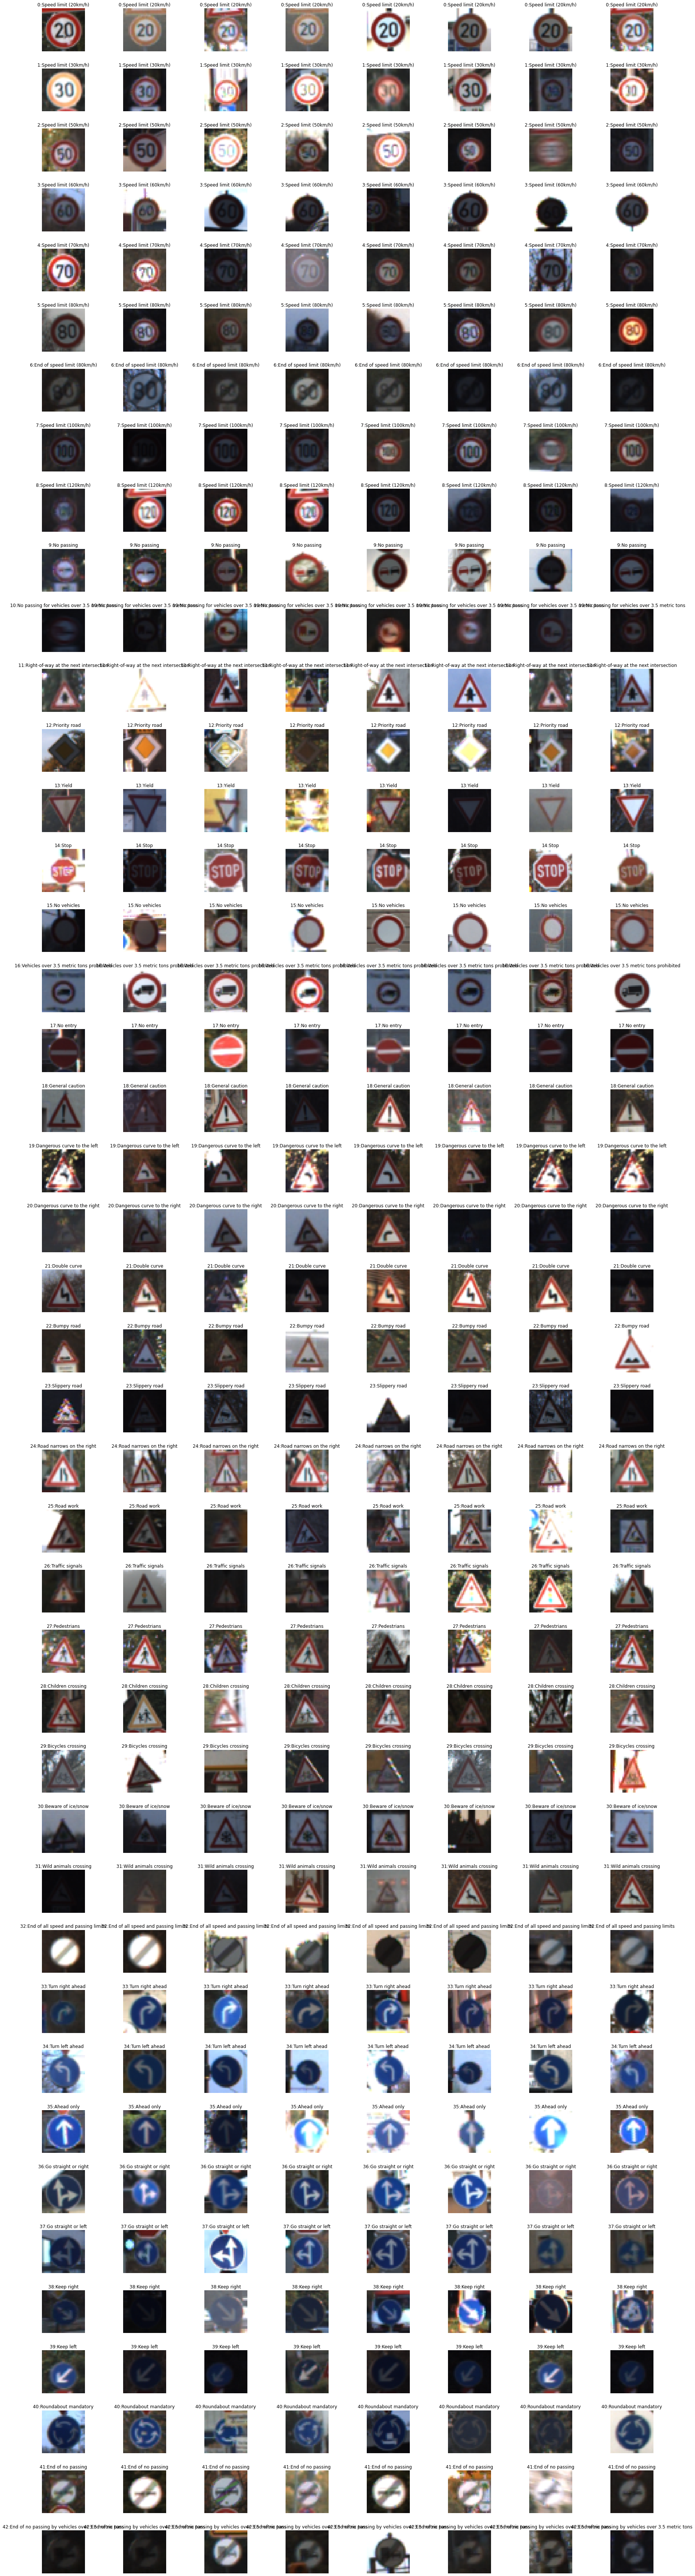

In [13]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

def show_dataset(X, y, sign_names, columns=8):
    #label = sign_names[:, 1]
    fig, axes = plt.subplots(len(np.unique(y)), columns, figsize=(30, 126))
    fig.subplots_adjust(hspace =0.4, wspace = 0.4)
    axes = axes.ravel() # flatten 5 x 5 matrix 
    classes = np.unique(y)
    for row , col in enumerate(classes):
        group = X[y == col]
        sign_name = sign_names[col]
        
        for i in range(columns):
            index = row * columns + i
            image = group[random.randint(0, len(group) - 1)]
            axes[index].axis('off')
            axes[index].set_title(str(sign_name[0]) + ":"+sign_name[1])
            if len(image.shape) == 3:
                axes[index].imshow(image)
            else:
                axes[index].imshow(image, cmap='gray')
    print("\n")
    plt.show()
show_dataset(X_train, y_train, sign_names)

# Step 3: Image Preprocessing

For many classification problems, the colors play little role, just shapes and edges, etc. In these cases, it may be helpful to use grayscale images instead of color images. Especially with large datasets, this speeds up the training process and can also have a positive effect on the achieved accuracy.

In [14]:
# from IPython.display import display, HTML

# display(HTML(data="""
# <style>
#     div#notebook-container    { width: 95%; }
#     div#menubar-container     { width: 65%; }
#     div#maintoolbar-container { width: 99%; }
# </style>
# """))

# from sklearn.utils import shuffle

# # converting images to grayscale
# def grayscale(images):
#     result = []
#     for image in images:
#         result.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
#     return np.array(result)

# X_train, y_train = shuffle(X_train, y_train)
# train_gray = grayscale(X_train)
# show_dataset(train_gray, y_train, sign_names)
# # i = random.randint(1, len(train_gray))
# # plt.imshow(train_gray[i].squeeze(), cmap = 'gray')
# # plt.figure()
# # plt.imshow(X_train[i])
# # plt.figure()
# # # plt.imshow(X_train_gray_norm[i].squeeze(), cmap = 'gray')


# Local Histogram Equalization
This technique simply distributes the most common intensity values in an image, improving low-contrast images.

In [15]:
# # histogram equalization
# def local_histogram_equalization(image):
#     kernel = morp.disk(30)
#     img_local = rank.equalize(image, selem=kernel)
#     return img_local

# train_equalized = np.array(list(map(local_histogram_equalization, train_gray)))
# show_dataset(train_equalized, y_train, sign_names)
# # i = random.randint(1, len(train_equalized))
# # plt.imshow(train_equalized[i], cmap = plt.cm.gray)
# # plt.axis('off')
# # plt.title("Histogram eqalization")
# # plt.figure()
# # plt.imshow(train_gray[i], cmap ='gray')
# # plt.axis('off')
# # plt.title("Grayscale")
# # plt.figure()

# Step 3: Image Augmentation

Image augmentation is a great technique for artificially propagating images of a dataset by duplicating existing images through random manipulations such as scaling, rotation, tilt, noise, ect.

# Zoom
I use random zoom between factor 0.5 and 1.5 to simulate different distances from the camera to the signs.

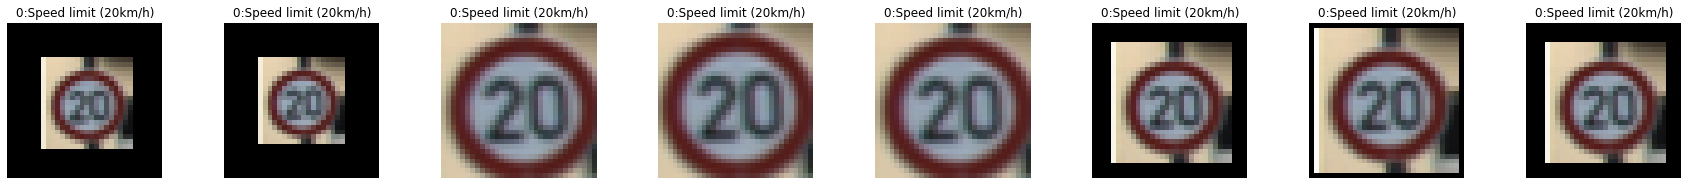

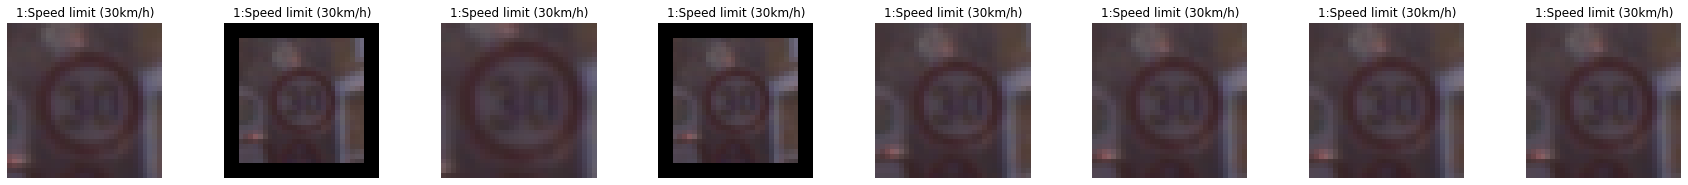

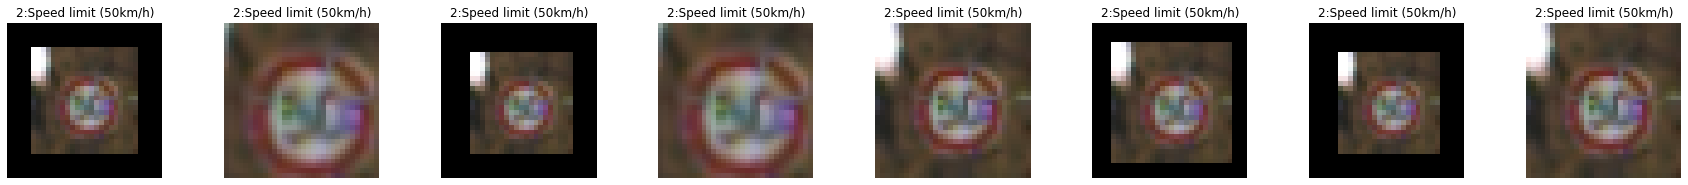

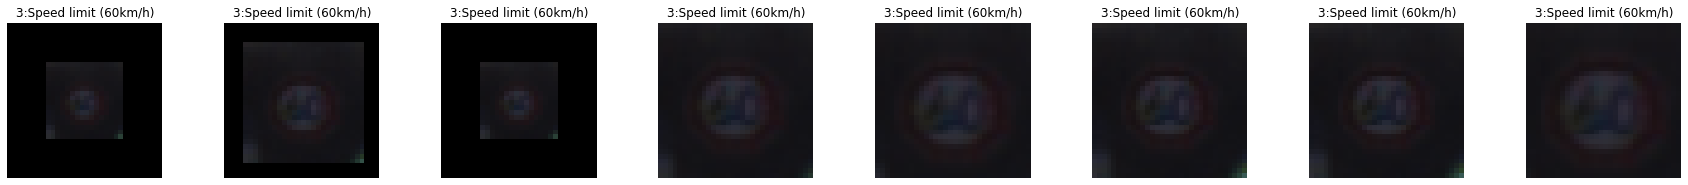

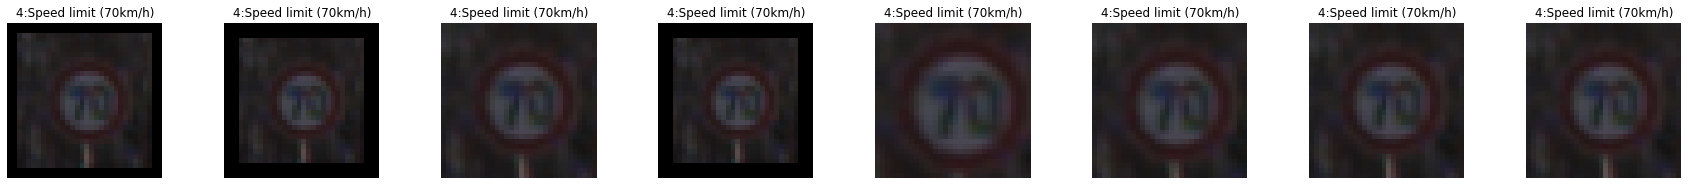

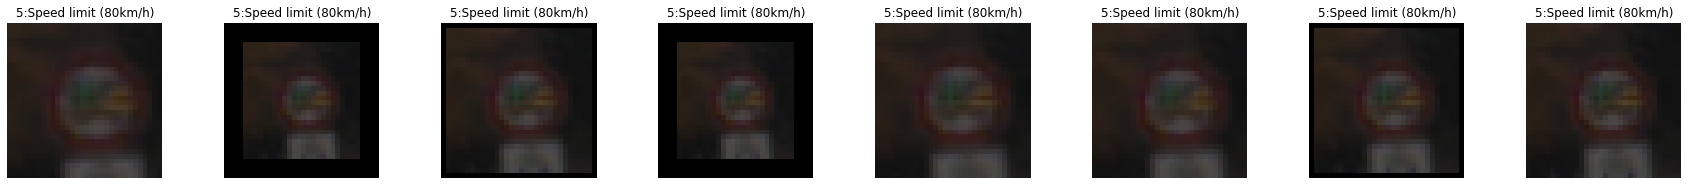

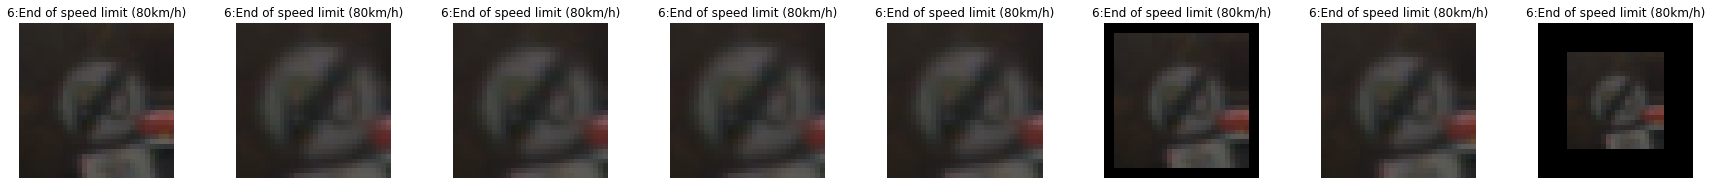

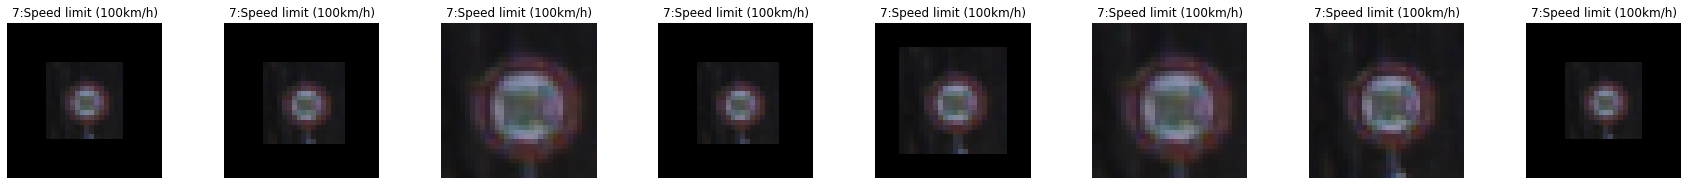

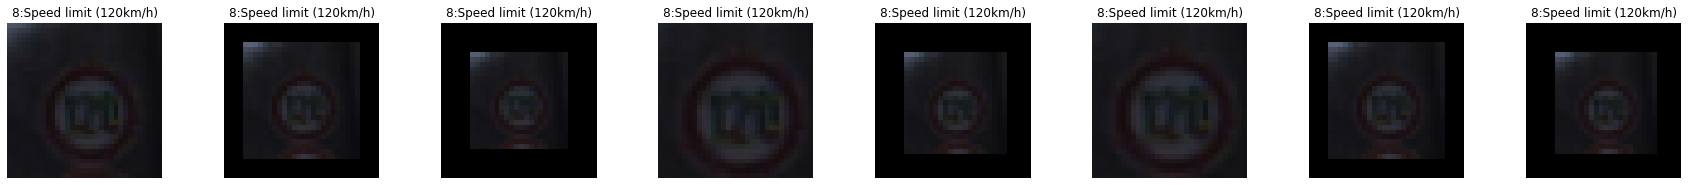

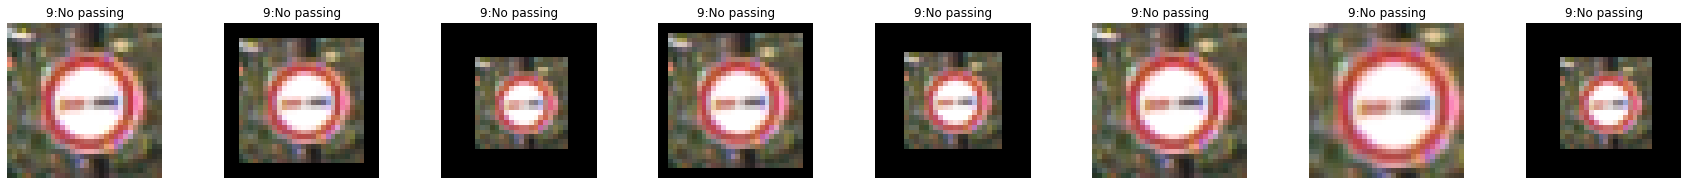

In [16]:
p = Augmentor.Pipeline()
p.zoom(probability=0.8, min_factor=0.5, max_factor=1.5)

for class_id in range(0, 10):
    y = np.nonzero(y_train == class_id)[0]
    x = X_train[y_train == class_id]

    datagen = p.keras_generator_from_array([x[0]], [class_id], batch_size=10)
    images, labels = next(datagen)
    show_dataset(images, labels, sign_names)

# Skew
I use a random horizontal respectively vertical tilt to simulate different camera perspectives on traffic signs.

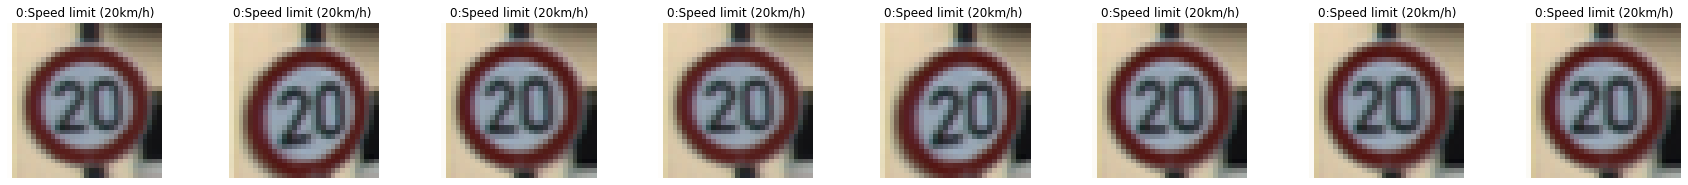

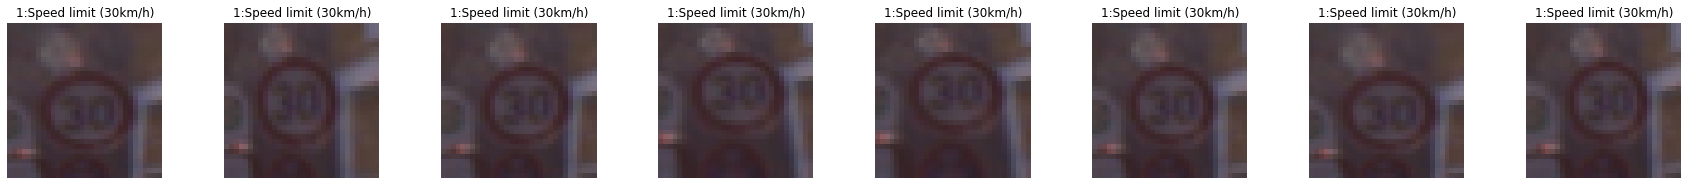

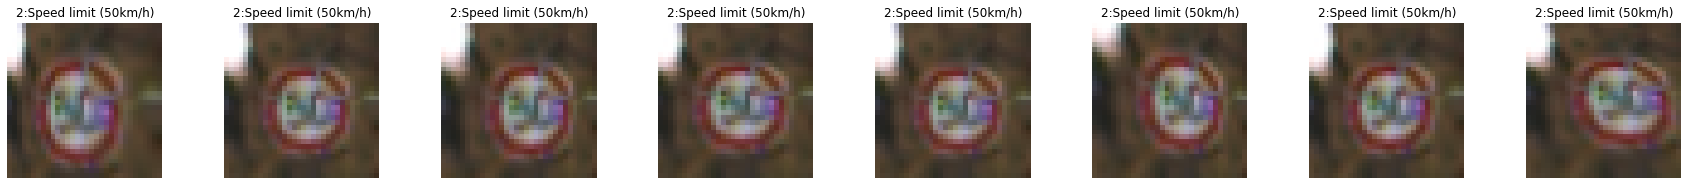

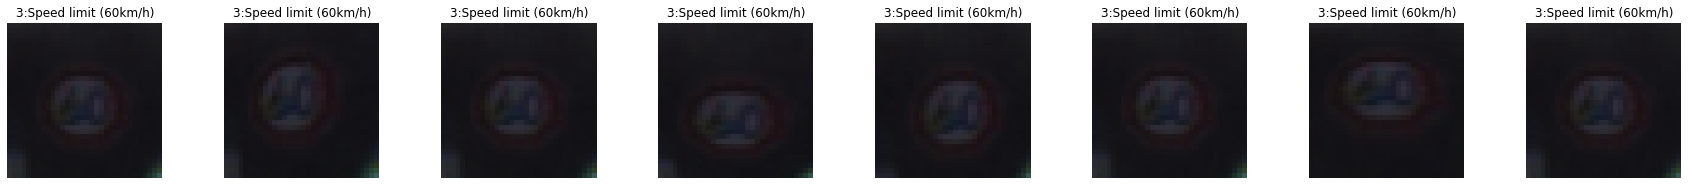

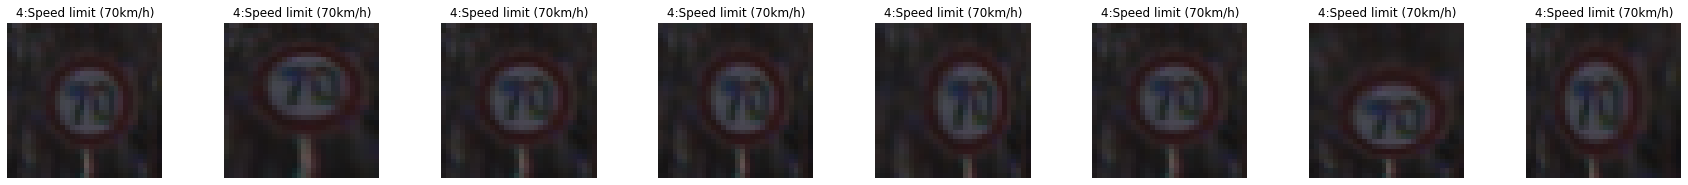

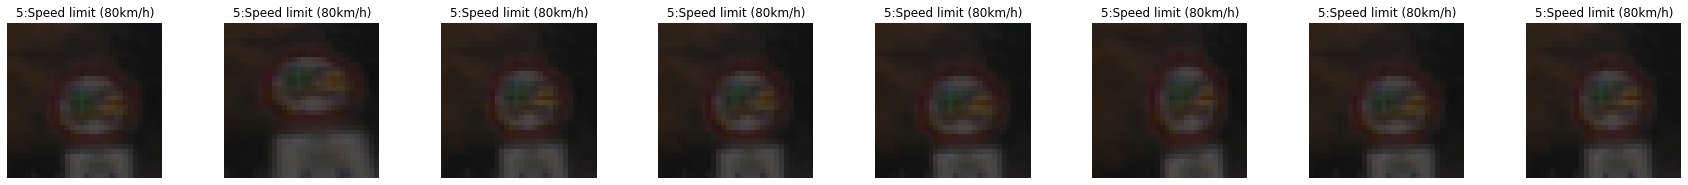

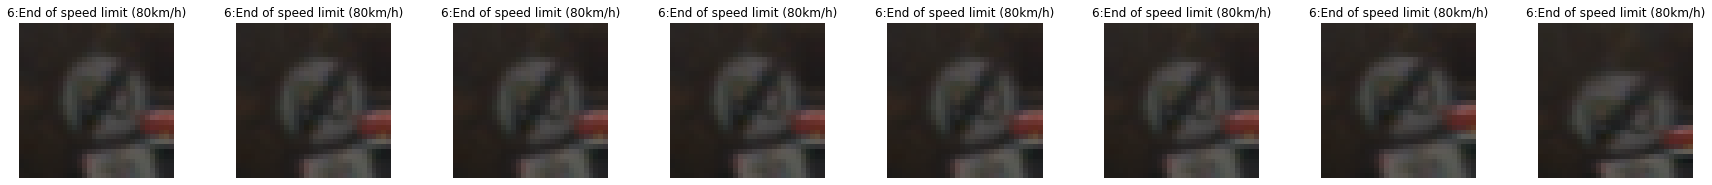

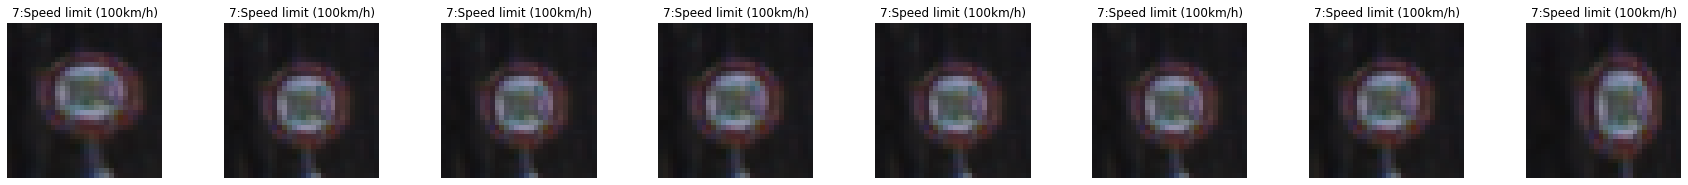

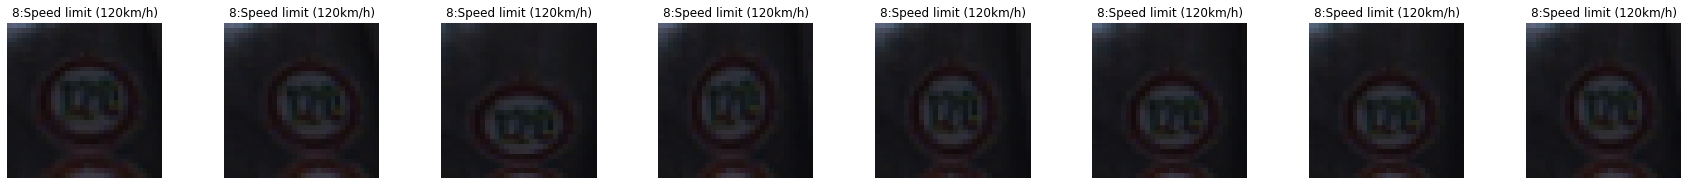

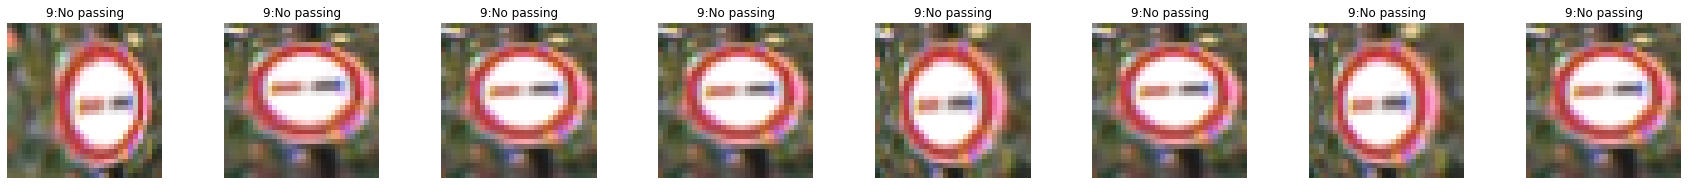

In [17]:
p = Augmentor.Pipeline()
p.skew(probability=0.8, magnitude=0.3)

for class_id in range(0, 10):
    y = np.nonzero(y_train == class_id)[0]
    x = X_train[y_train == class_id]

    datagen = p.keras_generator_from_array([x[0]], [class_id], batch_size=10)
    images, labels = next(datagen)
    show_dataset(images, labels, sign_names)

# Rotate
I use a random of +/- 18 degree rotation to simulate signs that appear slightly rotated.

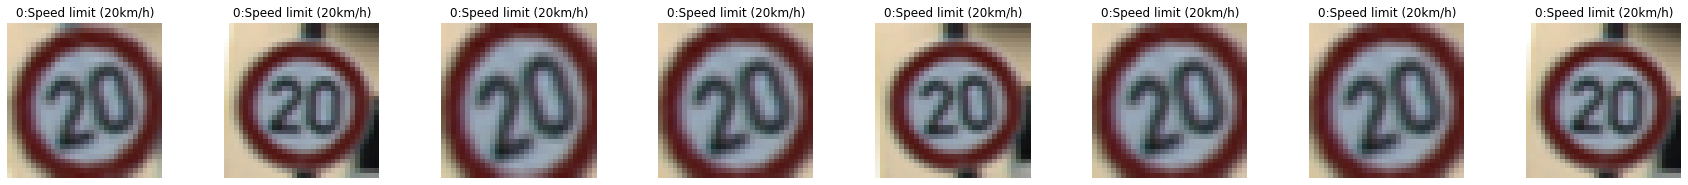

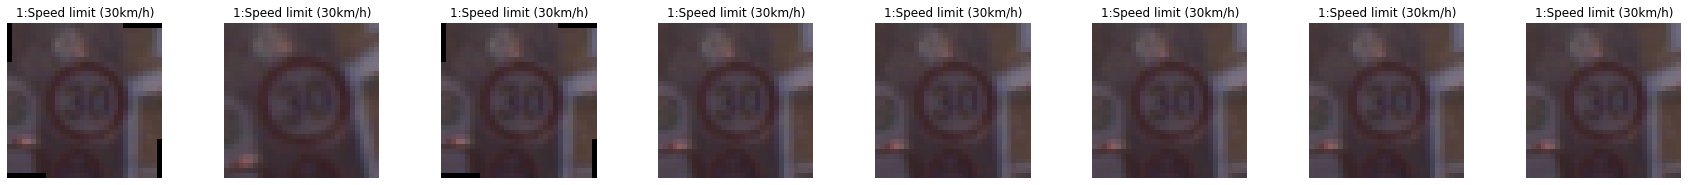

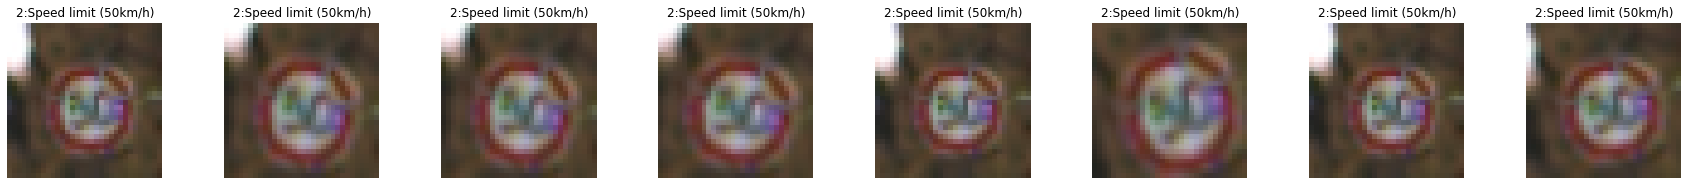

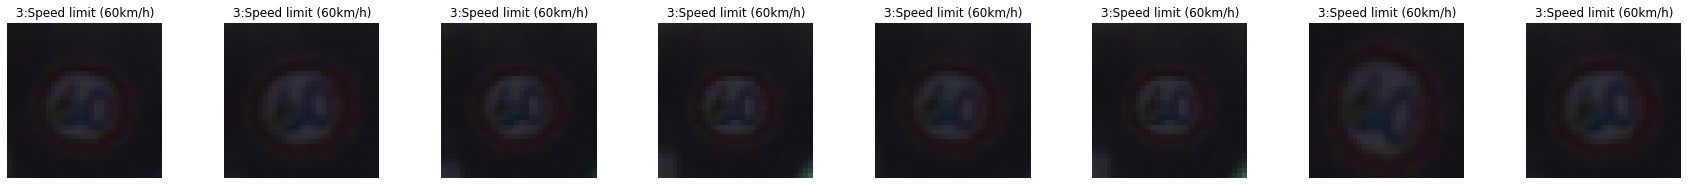

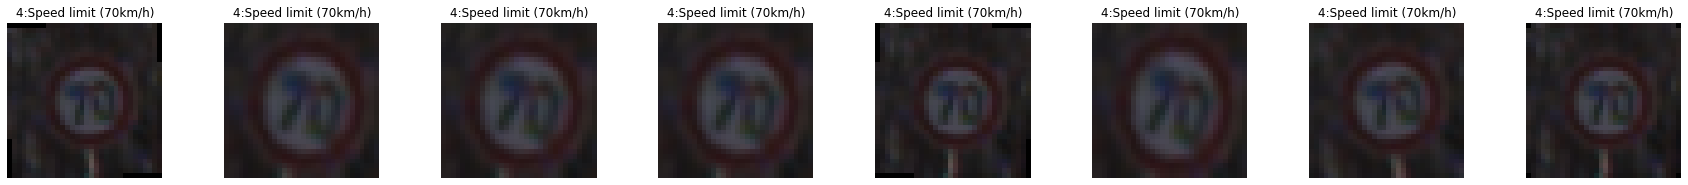

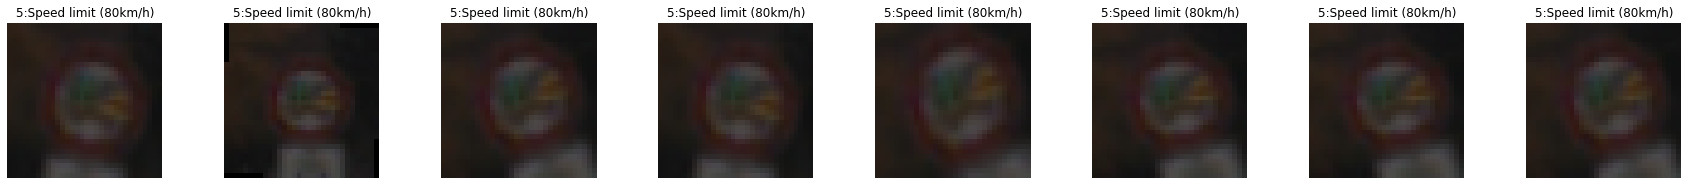

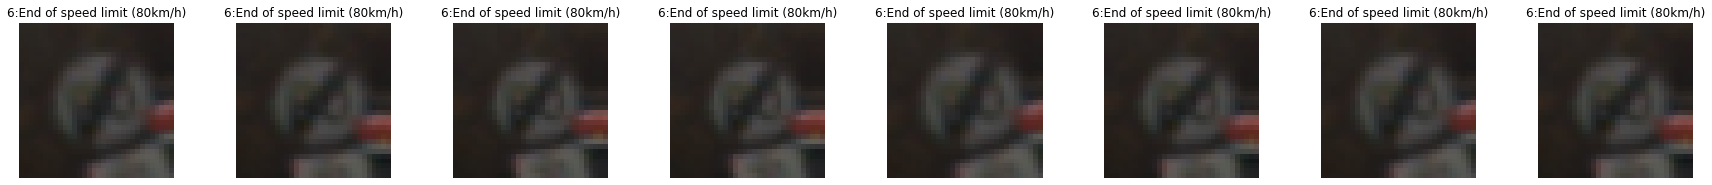

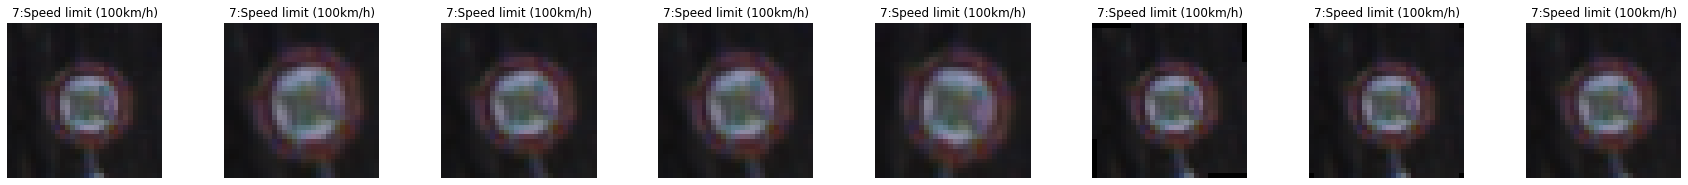

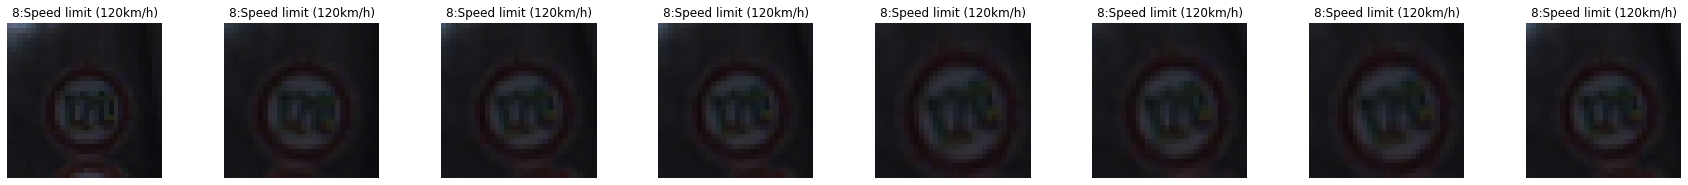

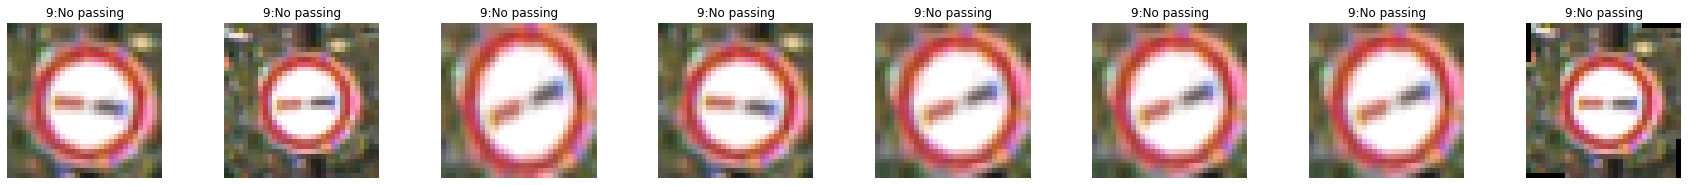

In [18]:
p = Augmentor.Pipeline()
p.rotate(probability=0.8, max_left_rotation=18, max_right_rotation=18)

for class_id in range(0, 10):
    y = np.nonzero(y_train == class_id)[0]
    x = X_train[y_train == class_id]

    datagen = p.keras_generator_from_array([x[0]], [class_id], batch_size=10)
    images, labels = next(datagen)
    show_dataset(images, labels, sign_names)

# Final Augmentation Pipeline
The final augmentation pipeline combines the three augmentation methods described above.


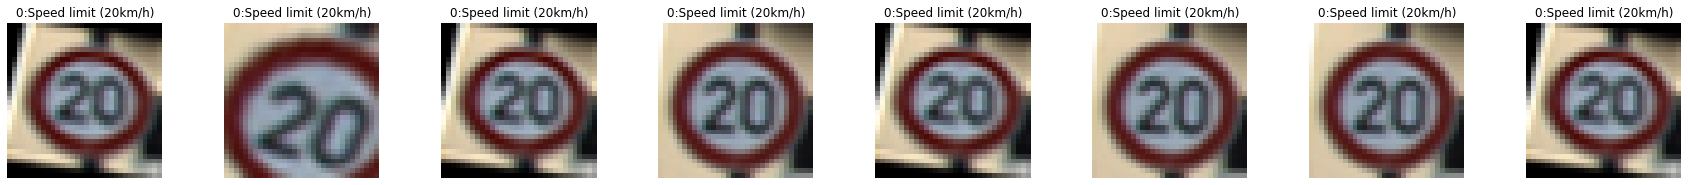

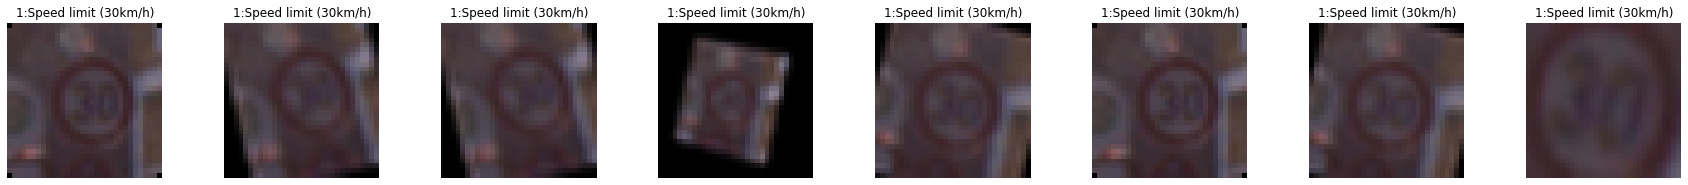

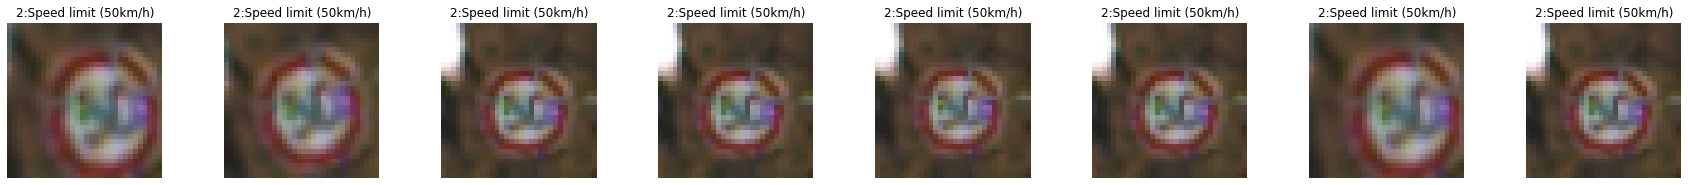

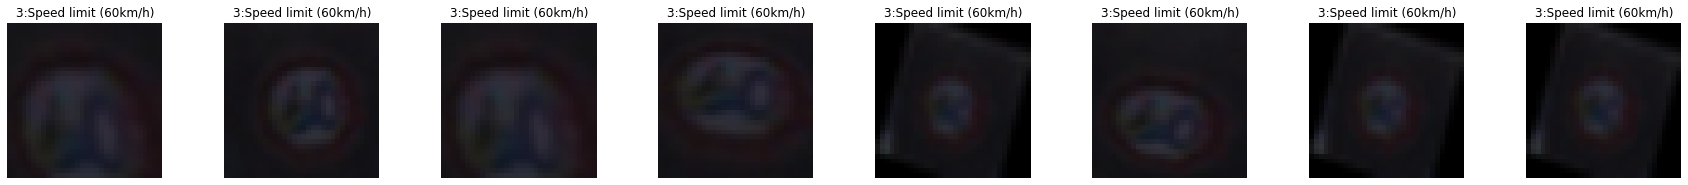

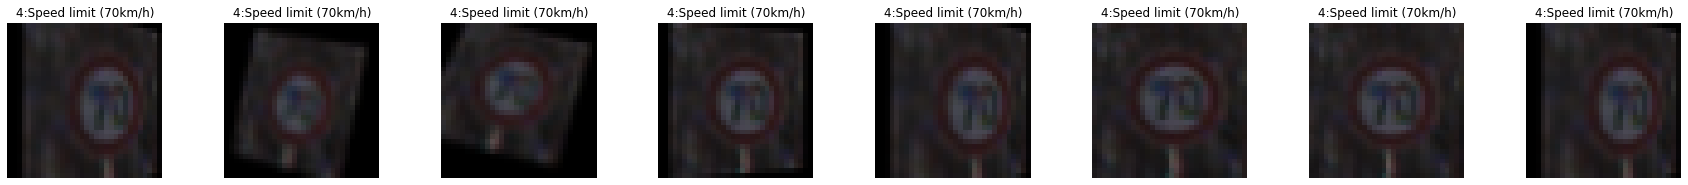

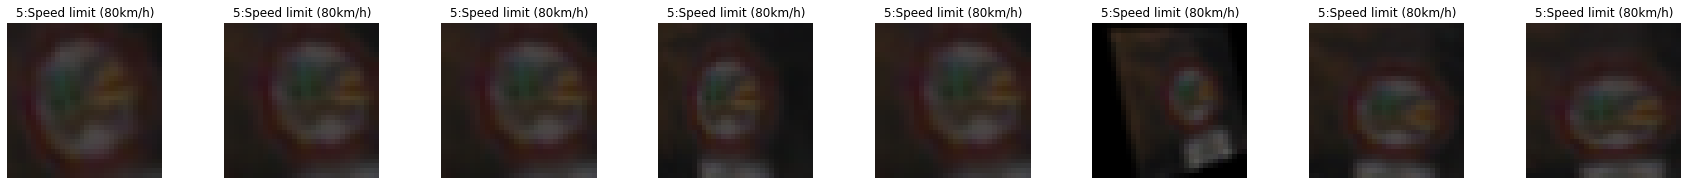

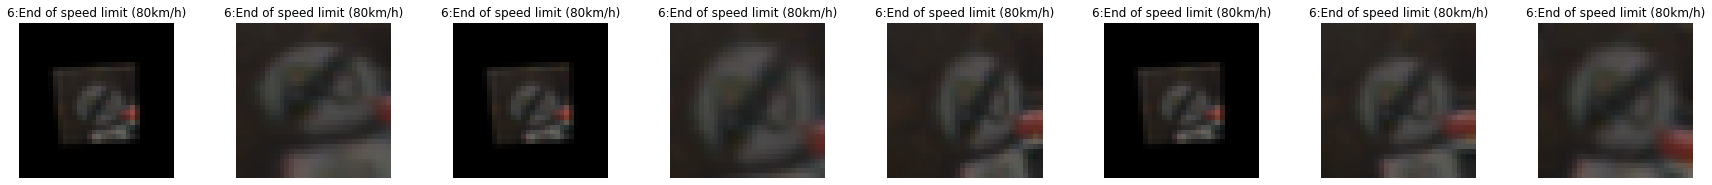

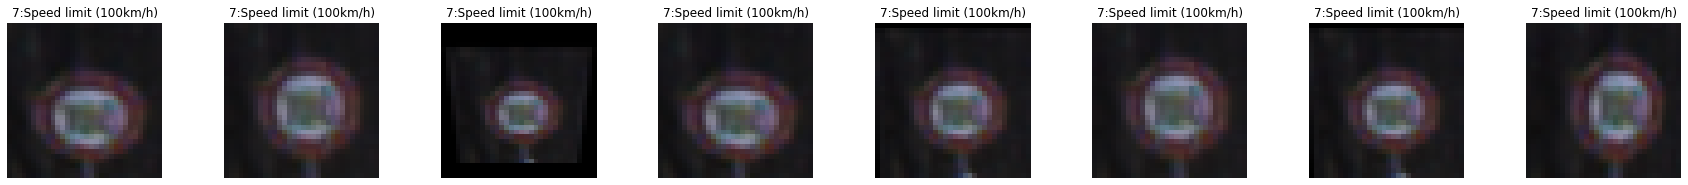

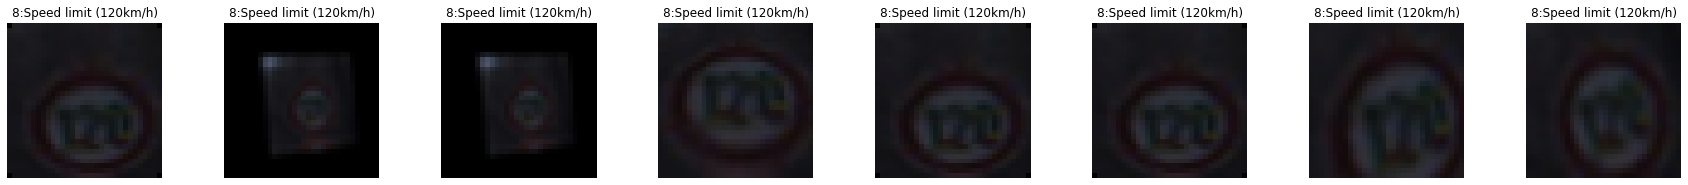

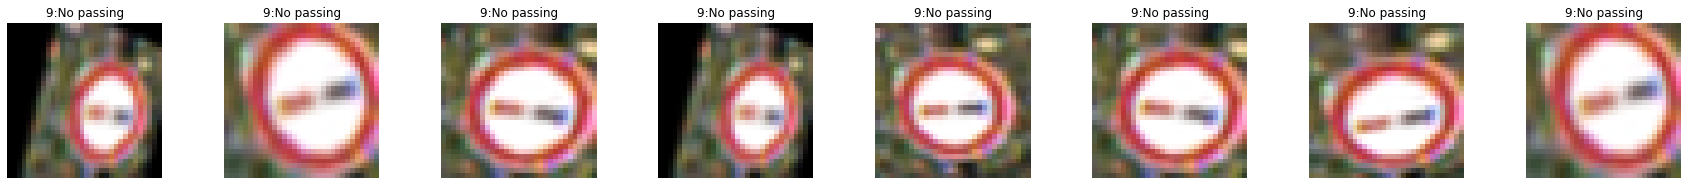

In [19]:
p = Augmentor.Pipeline()
p.zoom(probability=0.8, min_factor=0.5, max_factor=1.5)
p.skew(probability=0.8, magnitude=0.3)
p.rotate(probability=0.8, max_left_rotation=18, max_right_rotation=18)

for class_id in range(0, 10):
    y = np.nonzero(y_train == class_id)[0]
    x = X_train[y_train == class_id]

    datagen = p.keras_generator_from_array([x[0]], [class_id], batch_size=10)
    images, labels = next(datagen)
    show_dataset(images, labels, sign_names)

# Optimization Method

The following method allows to change the optimization method. So the network architecture can be easily tested with different optimization methods to select the best one.

In [20]:
def get_optimizer(optimizer_method):
    if optimizer_method == "sdg":
        return SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    if optimizer_method == "rmsprop":
        return RMSprop(lr=0.004, rho=0.9, epsilon=1e-08, decay=0.0)
    if optimizer_method == "adam":
        return Adam(learning_rate=0.004, decay=0.001 / num_epochs)
        # Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#     if optimizer_method == "adagrad":
#         return Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
#     if optimizer_method == "adadelta":
#         return Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)

# Callback Methods

I used three callback methods:

1. EarlyStopping: Stops the training process prematurely if no improvement has been achieved for several consecutive epochs.

2. ModelCheckpoint: Saves the best model ever learned after each epoch.

3. ReduceLROnPlateau: Automatically reduces the learning rate if no improvement has been achieved over several epochs.

In [21]:
def get_callbacks(model_architecture, optimizer_method):
    model_filepath = 'saved_data/traffic_signs_model_{}_{}.h5'.format(model_architecture, optimizer_method)
    callbacks = [
        EarlyStopping(monitor='loss', min_delta=0, patience=5, mode='auto', verbose=1),
        ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=1e-4, cooldown=0,
                          min_lr=0)]
    return callbacks

## Funciton to Plot the training and validation accuracy and loss

In [22]:
def plot_train_history(H, model_architecture, optimizer_method):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, len(H.history["loss"])), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, len(H.history["val_loss"])), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, len(H.history["accuracy"])), H.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, len(H.history["val_accuracy"])), H.history["val_accuracy"], label="val_accuracy")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig('saved_data/training-loss-and-accuracy_{}_{}.png'.format(model_architecture, optimizer_method))
    plt.show()

Here I normalize the images between 0.0 and 1.0. The image data should be normalized so that the data has mean zero and equal variance. I only do this for the validation data, because the image augmentor we use for the training data already supplies normalized data.

Also the class labels y_train and y_valid must be converted to one hot labels.

In [23]:
# normalize data between 0.0 and 1.0
# don't normalize X_train, because this is already done by the augmentation
X_valid = X_valid.astype('float32') / 255

# convert class vectors to binary class matrices.
y_train = utils.np_utils.to_categorical(y_train, n_classes)
y_valid = utils.np_utils.to_categorical(y_valid, n_classes)

In [24]:
# hyperparameter for training
optimizer_method = 'adam'
batch_size = 50
num_epochs = 100

# Step 4: Implementing Model

### Model Architecture

# VGGNet Architecture

The VGG network architecture was introduced by Simonyan and Zisserman in their 2014 paper, Very Deep Convolutional Networks for Large Scale Image Recognition. It is one of the highest performing Convolutional Neural Networks on the ImageNet.

VGGNet Architecture: VGGNet Architecture
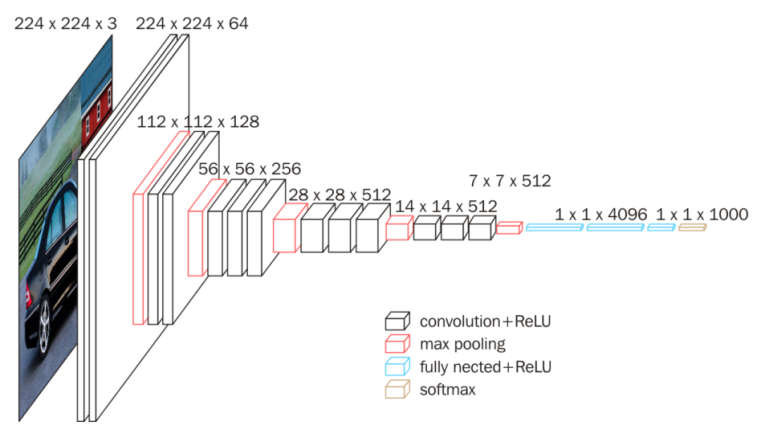

This network is characterized by its simplicity, using only 3×3 convolutional layers stacked on top of each other in increasing depth. Reducing volume size is handled by max pooling. Two fully-connected layers, each with 4,096 nodes are then followed by a softmax classifier.





In [25]:
# from tensorflow.keras import models, layers
class VGGNet:
    @staticmethod
    def build(n_classes):
        model = Sequential()
#         mdoel = models.Sequential()

        chanDim = -1

        # first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same", input_shape=(32, 32,3)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.20))

        # second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.20))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(n_classes))
        model.add(Activation("softmax"))

        # show and return the constructed network architecture
        model.summary()
        return model

# Step 5: Compiling and fitting the model

In [ ]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

from keras.models import Sequential

model_architecture = 'vggnet'

# image augmentation
datagen = p.keras_generator_from_array(X_train, y_train, batch_size=batch_size)

# build VGGNet model
vggnet_model = VGGNet.build(n_classes)

# the function to optimize is the cross entropy between the true label and the output (softmax) of the model
vggnet_model.compile(optimizer=get_optimizer(optimizer_method), loss='categorical_crossentropy', metrics=['accuracy'])

# train model
H = vggnet_model.fit_generator(datagen,
                               validation_data=(X_valid, y_valid),
                               steps_per_epoch=len(X_train) / batch_size,
                               callbacks=get_callbacks(model_architecture, optimizer_method),
                               epochs=num_epochs,
                               verbose=1)
print("\n")
# plot and save the training loss and accuracy
plot_train_history(H, model_architecture, optimizer_method)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

696/695 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9768 ETA: 0s - loss: 0.0766 - accuracy: 0.
Epoch 00014: val_loss improved from 0.06823 to 0.06614, saving model to saved_data\traffic_signs_model_vggnet_adam.h5
696/695 [==============================] - 64s 92ms/step - loss: 0.0765 - accuracy: 0.9768 - val_loss: 0.0661 - val_accuracy: 0.9830
Epoch 15/100
696/695 [==============================] - ETA: 0s - loss: 0.0691 - accuracy: 0.9778
Epoch 00015: val_loss did not improve from 0.06614
696/695 [==============================] - 63s 90ms/step - loss: 0.0691 - accuracy: 0.9778 - val_loss: 0.0663 - val_accuracy: 0.9834
Epoch 16/100
696/695 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.9773
Epoch 00016: val_loss improved from 0.06614 to 0.06555, saving model to saved_data\traffic_signs_model_vggnet_adam.h5
696/695 [==============================] - 64s 91ms/step - loss: 0.0716 - accuracy: 0.9773 - val_loss: 0.0655 - val_accuracy: 0.

# Step 6:  Testing the model performce on test data

In [26]:
model_architecture = 'vggnet'

with open(testing_data, mode='rb') as f:
    test = pickle.load(f)
    
X_test, y_test = test['features'], test['labels']

# convert class vector to binary class matrix.
y_test = utils.np_utils.to_categorical(y_test, n_classes)

# normalize data between 0.0 and 1.0
X_test = X_test.astype('float32') / 255


# load trained model
lenet_model = load_model('saved_data/traffic_signs_model_{}_{}.h5'.format(model_architecture, optimizer_method))
print()
# print loss and accuracy of the trained model
loss, acc = vggnet_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)
print('Loss:     {:.2f}%'.format(loss * 100))
print('Accuracy: {:.2f}%'.format(acc * 100))
print()

# show the true and the predicted classes for a couple of items of the test dataset
y_pred = vggnet_model.predict(X_test)

start = 150
count = 20
for i, (y_t, y_p) in enumerate(zip(y_test[start:start + count], y_pred[start:start + count])):
    print("{:4d} : True={: <2}  Predicted={: <2}  {}"
          .format(i + start, y_t.argmax(axis=-1), y_p.argmax(axis=-1),
                  y_t.argmax(axis=-1) == y_p.argmax(axis=-1)))
 

NameError: name 'vggnet_model' is not defined

# Step 7: Confusion matrix 
    - Accessing the trained CNN model to visualize the performance
    - Rows - plot the predicted class
    - cols - shows the true class

In [3]:
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize
plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot = True)
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig('saved_data/confusion_matrix.png')

NameError: name 'y_test' is not defined

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
    for axes, cfs_matrix, label in zip(ax.flatten(), y_test.argmax(axis=1), y_pred.argmax(axis=1)):
        print_confusion_matrix(cfs_matrix, axes, y_test.argmax(axis=1), ["N", "Y"])
    
    fig.tight_layout()
    plt.show()

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = ['SETOSA','VERSICOLR','VIRGINICA'], 
                     columns = ['SETOSA','VERSICOLR','VIRGINICA'])

# Visualization on prediction of test images

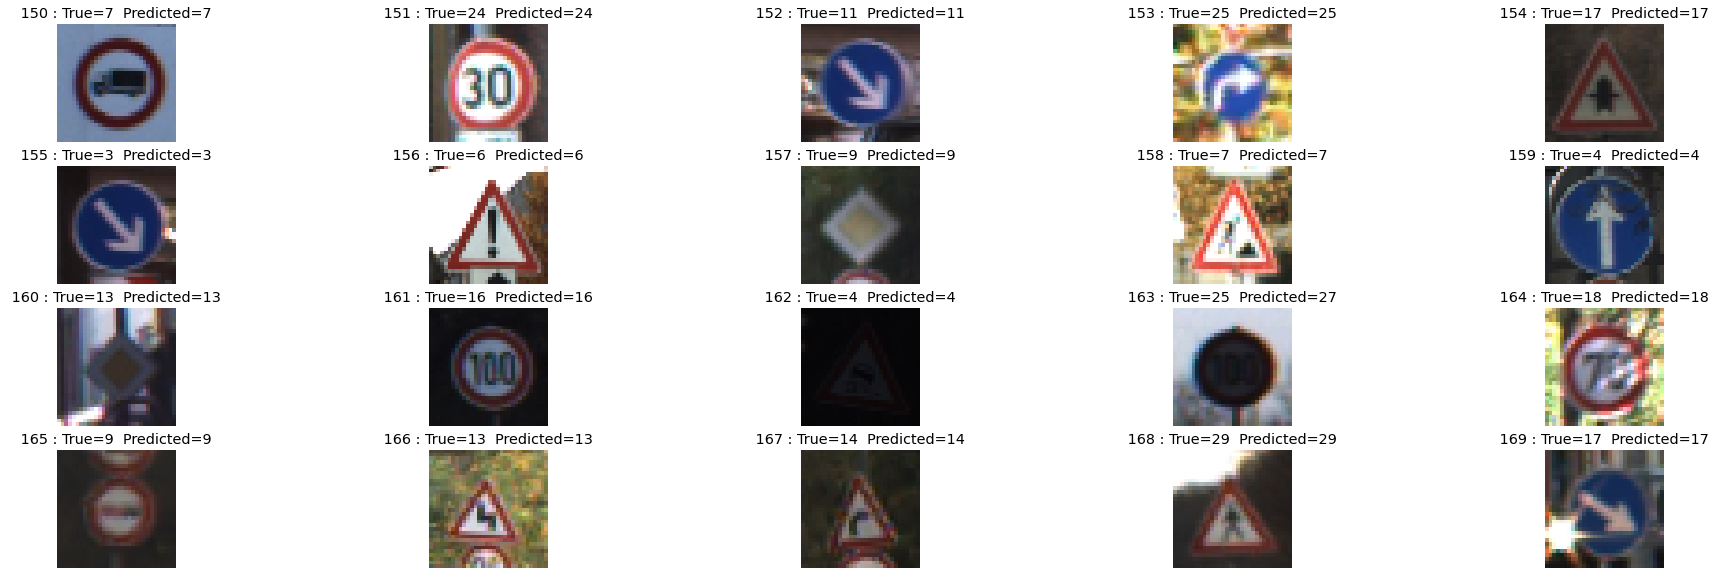

In [841]:

fig, axes = plt.subplots(4, 5, figsize = (30, 10))
axes = axes.ravel()

start = 150
count = 20
for i, (y_t, y_p) in enumerate(zip(y_test[start:start + count], y_pred[start:start + count])):
    axes[i].imshow(X_test[i])
    axes[i].set_title("{:4d} : True={:}  Predicted={:} ".format(i + start, y_t.argmax(axis=-1), y_p.argmax(axis=0)))  
    axes[i].axis('off')
plt.subplots_adjust(wspace = 1)  

# Step 8: Testing the model on new images
    Here the test images collected from the web is displayed

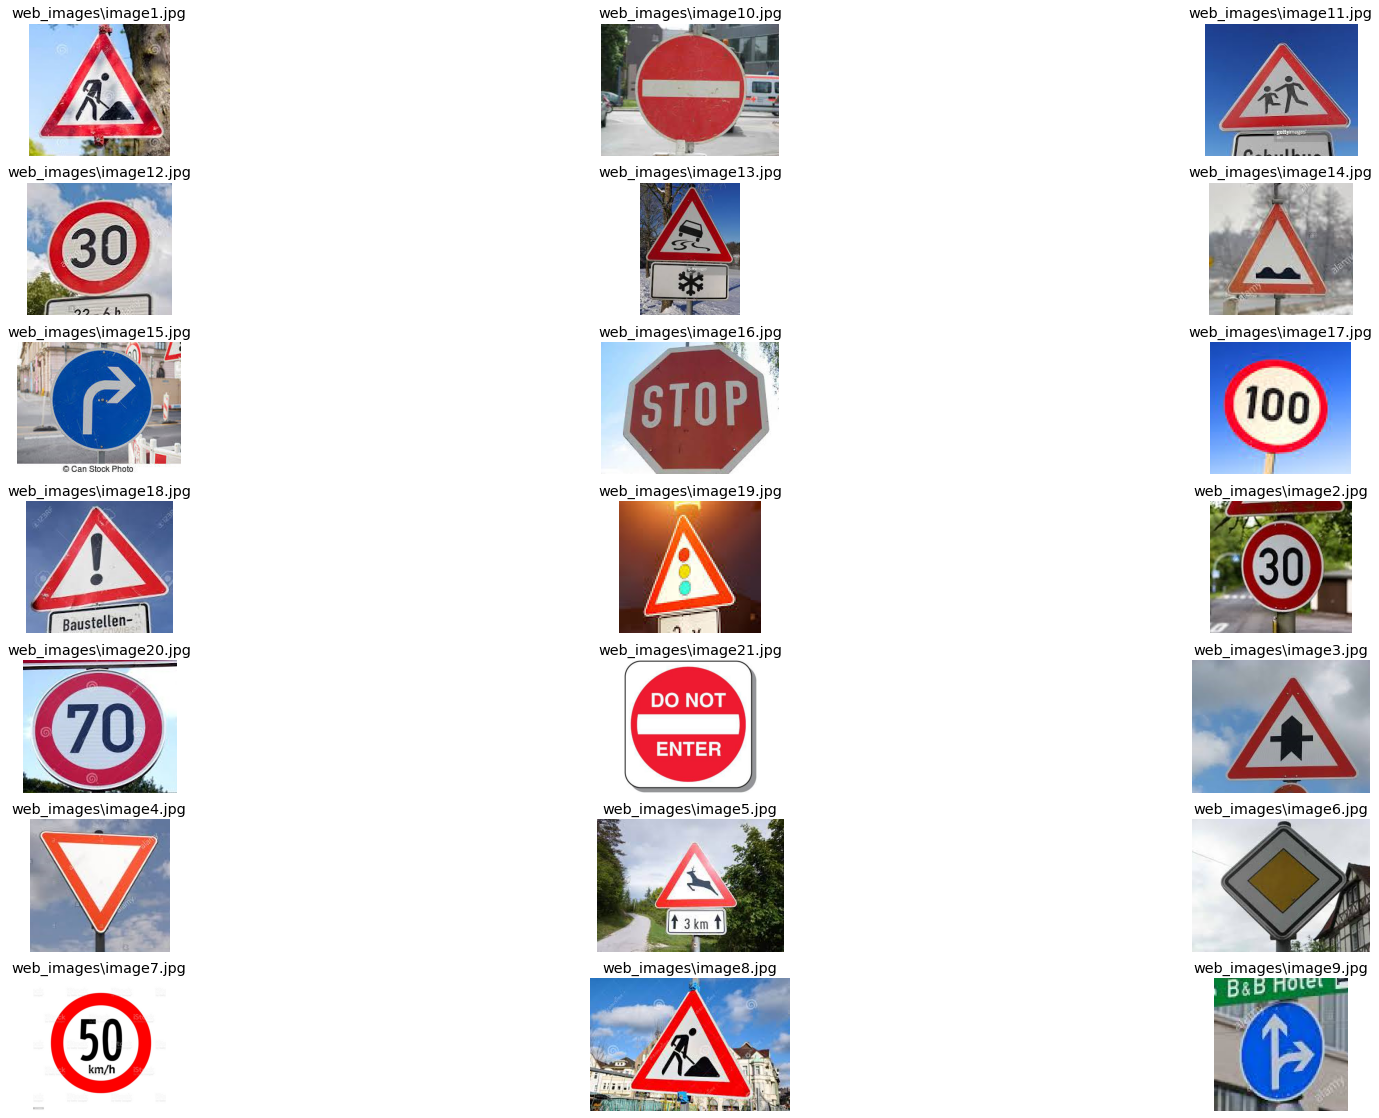

In [832]:
# show test images
filenames = glob.glob('web_images/*.jpg')
num_files = int(len(filenames))
cols = 3
rows = int(num_files/cols)

if num_files % cols > 0:
    rows += 1


fig, axes = plt.subplots(rows, cols, figsize=(30,20))
#     fig.subplots_adjust(hspace =0.4, wspace = 0.5)
axes = axes.ravel()


for i, filename in enumerate(filenames):
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[i].axis('off')
    axes[i].imshow(image)
    axes[i].set_title(filename)

plt.savefig('test_images_data/test_images.png')
plt.show()


## Predict the sign type for each test image


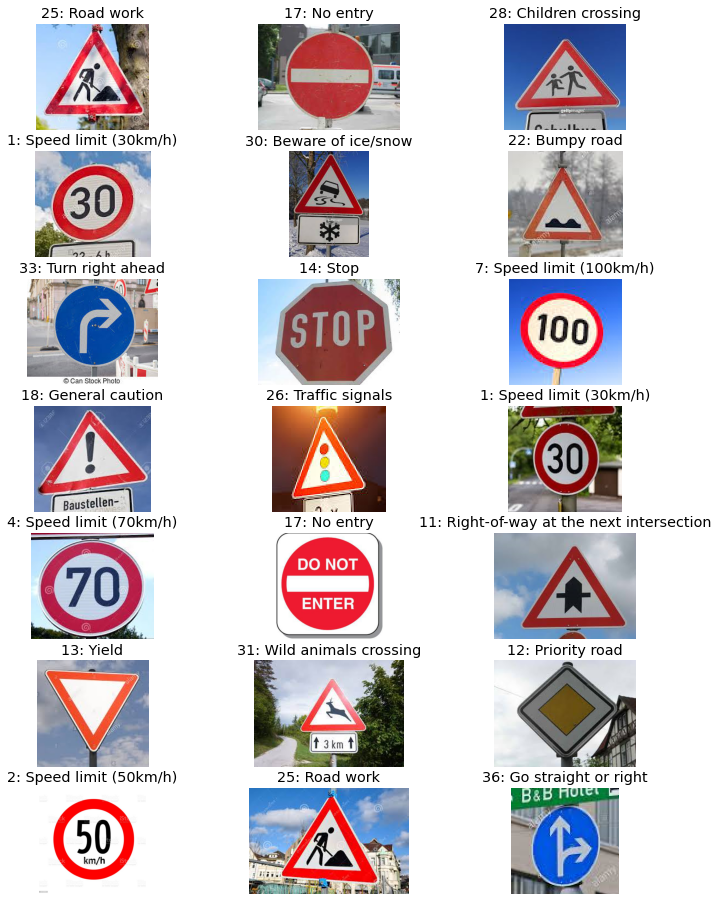

In [860]:
# read and preprocess test images
original_images = []
X_test = []
filenames = glob.glob('web_images/*.jpg')
for filename in filenames:
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_images.append(image)
    resized_image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_AREA)
    X_test.append(resized_image)

X_test = np.array(X_test)

# normalize data between 0.0 and 1.0
X_test = X_test.astype('float32') / 255

# load trained vggnet model
model = load_model('saved_data/traffic_signs_model_{}_{}.h5'.format('vggnet', 'adam'))

# predict
y_pred = model.predict(X_test)

# show test images with class predictions
num_files = int(len(filenames))
cols = 3
rows = int(num_files / cols)
if num_files % cols > 0:
    rows += 1

fig, axes = plt.subplots(rows, cols, figsize=(12, 16))
axes = axes.ravel()

    
for i, (filename, image, org_image) in enumerate(zip(filenames, X_test, original_images)):
    class_id = y_pred.argmax(axis=-1)[i]
    class_name = sign_names[class_id][1]
    axes[i].imshow(org_image)
    axes[i].set_title('{}: {}'.format(class_id, class_name))
    axes[i].axis('off')

plt.savefig('test_images_data/test_images_predictions.png')
plt.show()

 

## Here the model's performance is tested on images collected from the web

In [861]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

sign_names = load_signnames_from_csv('signnames.csv')

for sign in sign_names:
    print('{:4d}: {}'.format(int(sign[0]), sign[1]))
    
y_true = np.array([25, 17, 28, 1, 30, 22, 33, 14, 7, 18, 26, 1, 4, 17, 11, 13, 31, 12, 2, 25, 36])
print("\nTrue:" + (str(y_true)))
print("\nPredicted:" + (str(y_pred.argmax(axis=-1))))
test_accuracy = sum(y_true == y_pred.argmax(axis=-1))/len(y_true)
print("Test Accuracy = {:.1f}%".format(test_accuracy*100))

   0: Speed limit (20km/h)
   1: Speed limit (30km/h)
   2: Speed limit (50km/h)
   3: Speed limit (60km/h)
   4: Speed limit (70km/h)
   5: Speed limit (80km/h)
   6: End of speed limit (80km/h)
   7: Speed limit (100km/h)
   8: Speed limit (120km/h)
   9: No passing
  10: No passing for vehicles over 3.5 metric tons
  11: Right-of-way at the next intersection
  12: Priority road
  13: Yield
  14: Stop
  15: No vehicles
  16: Vehicles over 3.5 metric tons prohibited
  17: No entry
  18: General caution
  19: Dangerous curve to the left
  20: Dangerous curve to the right
  21: Double curve
  22: Bumpy road
  23: Slippery road
  24: Road narrows on the right
  25: Road work
  26: Traffic signals
  27: Pedestrians
  28: Children crossing
  29: Bicycles crossing
  30: Beware of ice/snow
  31: Wild animals crossing
  32: End of all speed and passing limits
  33: Turn right ahead
  34: Turn left ahead
  35: Ahead only
  36: Go straight or right
  37: Go straight or left
  38: Keep right
  3

# Step 9: Displaying top 5 softmax probabilities for each image found on the web
    - For each of the new images, displayed the model's softmax probabilities to network traget classes for each image
    - limit the output to the top 5 probabilities for each image.

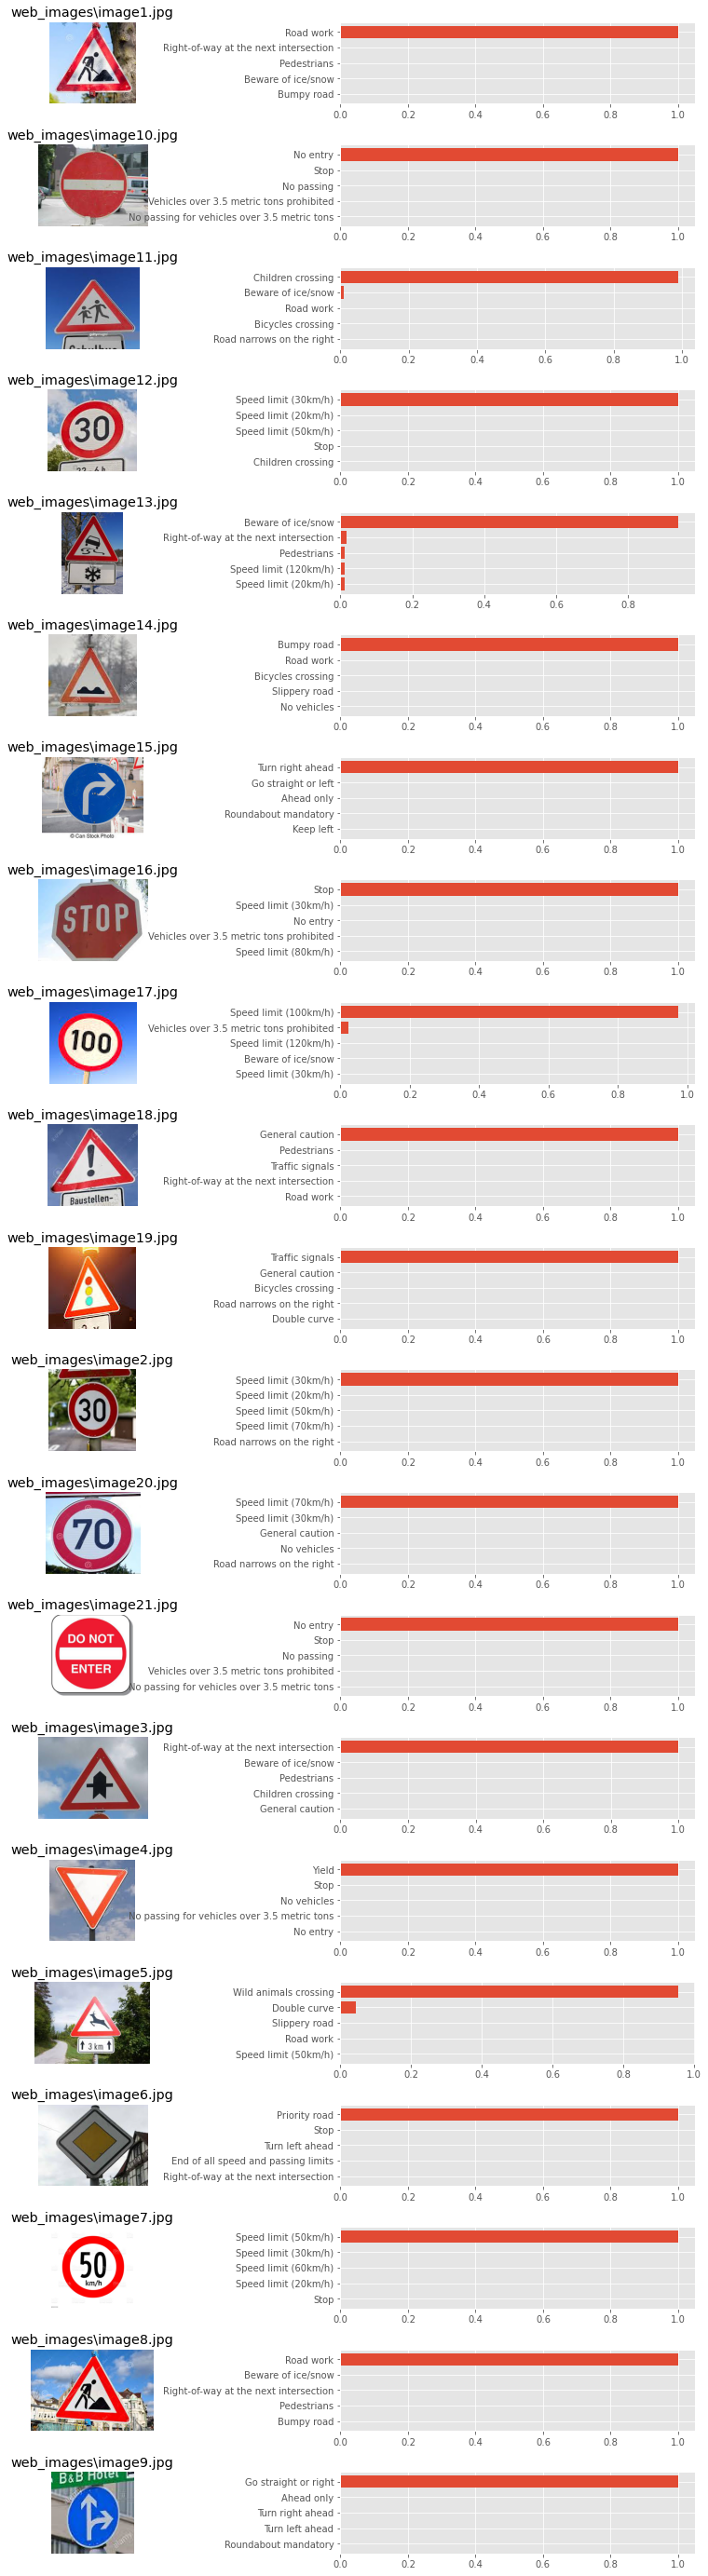

In [862]:
# from IPython.display import display, HTML
# display(HTML(data="""
# <style>
#     div#notebook-container    { width: 95%; }
#     div#menubar-container     { width: 65%; }
#     div#maintoolbar-container { width: 99%; }
# </style>
# """))

### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 

k = 5
n = len(filenames)
plt.figure(figsize=(15, 50))
plt.subplots_adjust(hspace=0.5)
for i, (filename, prob, org_image) in enumerate(zip(filenames, y_pred, original_images)):
    top_values_index = sorted(range(len(prob)), key=lambda p: prob[p])[-k:]
    class_id = prob.argmax(axis=-1)
    class_name = sign_names[class_id][1]
    plt.subplot(n, 2, 2 * i + 1)
    plt.imshow(original_images[i])
    plt.title(filename)
    plt.axis('off')
    plt.subplot(n, 2, 2 * i + 2)
    plt.barh(np.arange(1, 6, 1), prob[top_values_index])
    labels = np.array([sign_names[j] for j in top_values_index])
    plt.yticks(np.arange(1, 6, 1), labels[:, 1])
    
plt.savefig('saved_data/top-5-predictions.png')
plt.show()